In [1]:
import tensorflow as tf
import keras_tuner
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib

import decomposition
import models
import data
from metrics import smape
from windower import WindowGenerator
import hp_training
import results

2023-03-16 10:54:31.387164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]
gonem_directory = code_directory / "notebooks" / "Gonem"
data_directory = code_directory / "data"
hp_directory = code_directory / "hp"
scenario_directory = code_directory / "scenarios"
model_directory = code_directory / 'models'

model = 'SS' # SS, ARF or ED
product = 'maize' # maize, sunflower or wheat 

data_type = 'out_sample' # in_sample or out_sample
scenario = 1

model_path =  model_directory / f"{model}_{product}"
checkpoint_path = model_path / f"{model}_{product}"

results_path = model_directory / f"{model}_{product}"

results_path

scenario_files = []
for path in pathlib.Path(scenario_directory).iterdir():
    if path.is_file():
        scenario_files.append(path.name)

In [17]:
if scenario:
    data_type = f"{scenario_files[scenario-1]}"
    print(data_type)
    df = data.get_data(scenario_directory / scenario_files[scenario-1])
else:
    df = data.get_data(directory_path=data_directory, product=product)


df = df.iloc[:-2]
df.describe()

SCENARIO_PRICEINCLUDED_OIL_SHOCK_SUPPLYSHIFT_TEMPERATURE_MAIZE_[210, 193, 190, 213, 198, 202, 207, 212, 205, 198, 211, 206, 211]_2023-03-16_11-01-08.xlsx


AVG_TAVG                                         \
PARTNER_Labels       Brazil       France      Germany      Hungary   
count            212.000000   212.000000   212.000000   212.000000   
mean             280.989891   155.914398   131.052868   147.409758   
std              255.031856   233.516793   221.490389   255.378206   
min              146.692308    20.168095   -29.860742   -50.419892   
25%              231.165698    77.805790    47.985468    42.248987   
50%              248.147246   126.110638   109.118687   124.698987   
75%              256.548347   181.241982   169.041138   194.846667   
max             3131.572255  3128.087502  2943.670320  3347.338173   

                            Corn Price Futures     MAX_TMAX               \
PARTNER_Labels      Ukraine             Global       Brazil       France   
count            212.000000         212.000000   212.000000   212.000000   
mean             123.610096         447.205189   409.469515   276.924235   
std              245.210867         150.596080   386.640044   358.791666   
min              -98.247057         201.750000   282.000000   107.622222   
25%               16.463480         356.437500   331.875000   166.624526   
50%               94.442279         389.625000   347.000000   230.850287   
75%              188.432803         555.750000   369.625000   292.052083   
max             3165.324786         818.250000  4920.194559  4700.668891   

                                          ...  \
PARTNER_Labels      Germany      Hungary  ...   
count            212.000000   212.000000  ...   
mean             269.674100   292.687273  ...   
std              372.922161   384.707420  ...   
min               36.388889    43.666667  ...   
25%              146.555556   166.812500  ...   
50%              229.138889   248.425000  ...   
75%              293.367647   321.050000  ...   
max             4950.878395  5011.831420  ...   

               renewable_energy_consumption_perc_of_total              \
PARTNER_Labels                                     Brazil      France   
count                                          212.000000  212.000000   
mean                                            45.961321   12.858797   
std                                              1.909219    2.269171   
min                                             41.710000    8.520000   
25%                                             44.839375   11.130833   
50%                                             46.680417   13.277500   
75%                                             47.570000   15.270000   
max                                             48.920000   15.530000   

                                                   unemployment_total  \
PARTNER_Labels     Germany     Hungary     Ukraine             Brazil   
count           212.000000  212.000000  212.000000         212.000000   
mean             13.605825   13.299269    4.511203          10.096958   
std               2.843999    2.701251    2.124186           2.280336   
min               7.280000    7.290000    1.270000           6.760000   
25%              11.072292   12.753125    2.807500           8.174167   
50%              13.938750   13.640000    3.497917           9.502083   
75%              16.316875   15.388750    7.017500          12.416250   
max              17.170000   17.180000    7.440000          13.700000   

                                                                
PARTNER_Labels      France     Germany     Hungary     Ukraine  
count           212.000000  212.000000  212.000000  212.000000  
mean              8.980330    5.606981    7.008726    8.350071  
std               0.864391    2.218326    2.706634    1.099230  
min               7.390000    3.140000    3.420000    6.350000  
25%               8.110625    3.664375    4.084583    7.462500  
50%               9.101250    5.032083    7.355833    8.503750  
75%               9.801875    7.435208    9.591042    9.272500  
max              10

In [18]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Global'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [19]:
stl = decomposition.STLDecomposer(labels=label_columns, period=12)
log = decomposition.Logger(labels=label_columns)
std = decomposition.Standardizer()

preproc = decomposition.Processor().add(stl).add(log).add(std)

In [20]:
width = 24
label_width = 6
shift = 6

if data_type == 'in_sample':
    test_begin = None
else:
    test_begin = 0.
    
window = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    # train_begin=0, train_end=.9, val_begin=None, val_end=.96,
                    train_begin=0., train_end=.97, val_begin=None, val_end=None,
                    # train_begin=0, train_end=.5, val_begin=None, val_end=.8,
                    test_begin=test_begin, test_end=1., connect=True, remove_labels=True, label_columns=label_columns)
window.preprocess(preproc)
window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): [('price', 'Brazil'), ('price', 'France'), ('price', 'Germany'), ('price', 'Global'), ('price', 'Hungary'), ('price', 'Ukraine')]

In [21]:
label_std = decomposition.Standardizer(mean=std.mean[window.label_columns], std=std.std[window.label_columns])
label_log = decomposition.Logger(label_indices=range(len(window.label_columns)))
postproc = decomposition.Processor().add(label_std).add(label_log)
window.add_label_postprocess(postproc)

In [22]:
tuner = hp_training.get_tuner(model, hp_directory, window)

INFO:tensorflow:Reloading Tuner from /code/hp/SS/tuner0.json


In [9]:
for example_inputs, example_labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    output_features = example_labels.shape[-1]

Inputs shape (batch, time, features): (32, 24, 75)
Labels shape (batch, time, features): (32, 6, 6)


# Here we train the best hp model and give it a final training

In [10]:
# hp_training.run(tuner, window)

In [23]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'lstm_units': 416,
 'lstm_layers': 0,
 'dense_units': 416,
 'dense_layers': 0,
 'heads': 2,
 'dropout': 0.38972766578190643,
 'key_dim': 128,
 'l1': 0.0009215140300448076,
 'l2': 0.0002556079498371441,
 'learning_rate': 0.0012848169081952467,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0203'}

In [74]:
hp_training.final_train(tuner, window, checkpoint_path)

Epoch 1/200
6/6 - 3s - loss: 162.3939 - mae: 0.7968 - mse: 1.0763 - mape: 456.9569 - smape: 151.6979 - val_loss: 150.0424 - val_mae: 1.0655 - val_mse: 1.7891 - val_mape: 735.9118 - val_smape: 139.7096 - 3s/epoch - 501ms/step
Epoch 2/200
6/6 - 0s - loss: 152.0833 - mae: 1.2019 - mse: 2.2263 - mape: 1002.1491 - smape: 141.5304 - val_loss: 142.9223 - val_mae: 1.0441 - val_mse: 1.7607 - val_mape: 941.3741 - val_smape: 132.8367 - 367ms/epoch - 61ms/step
Epoch 3/200
6/6 - 0s - loss: 139.9076 - mae: 0.9928 - mse: 1.6152 - mape: 895.7708 - smape: 129.1230 - val_loss: 130.6143 - val_mae: 0.8430 - val_mse: 1.2422 - val_mape: 862.5045 - val_smape: 120.0276 - 310ms/epoch - 52ms/step
Epoch 4/200
6/6 - 0s - loss: 133.3423 - mae: 0.8576 - mse: 1.2635 - mape: 769.1160 - smape: 122.8964 - val_loss: 126.7406 - val_mae: 0.7664 - val_mse: 1.0492 - val_mape: 766.6176 - val_smape: 116.3897 - 306ms/epoch - 51ms/step
Epoch 5/200
6/6 - 0s - loss: 127.3250 - mae: 0.7748 - mse: 1.0608 - mape: 871.5167 - smape: 1

# From here on out, it is assumed that best_model is found

In [24]:
m = tuner.hypermodel.build(best_hps)
m.load_weights(checkpoint_path)
# m.evaluate(window.test)

('price', 'Brazil')


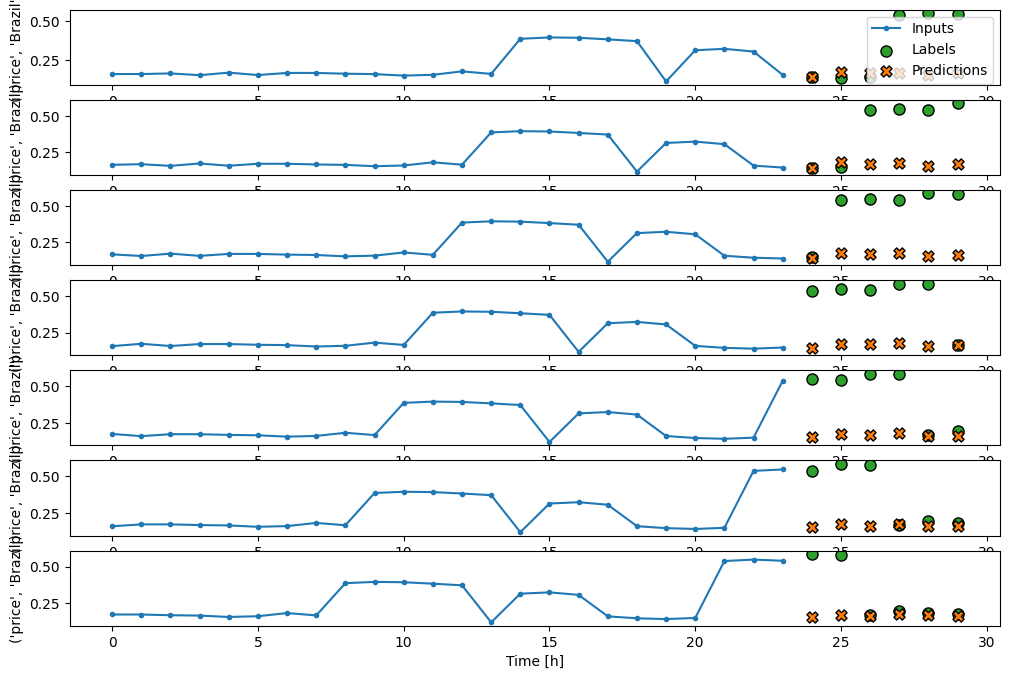

('price', 'France')


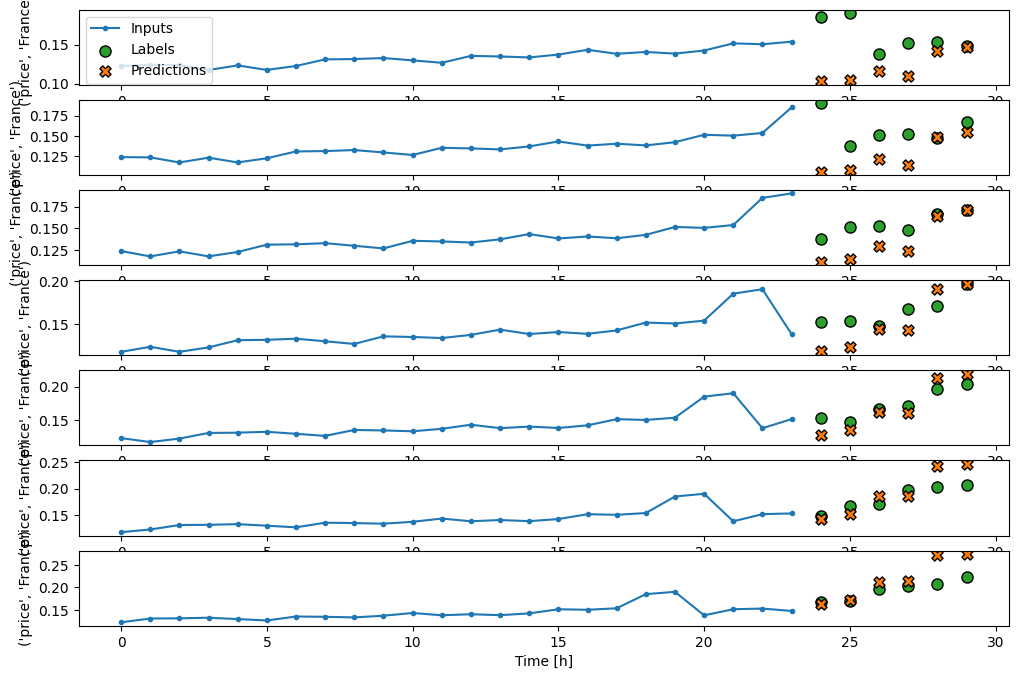

('price', 'Germany')


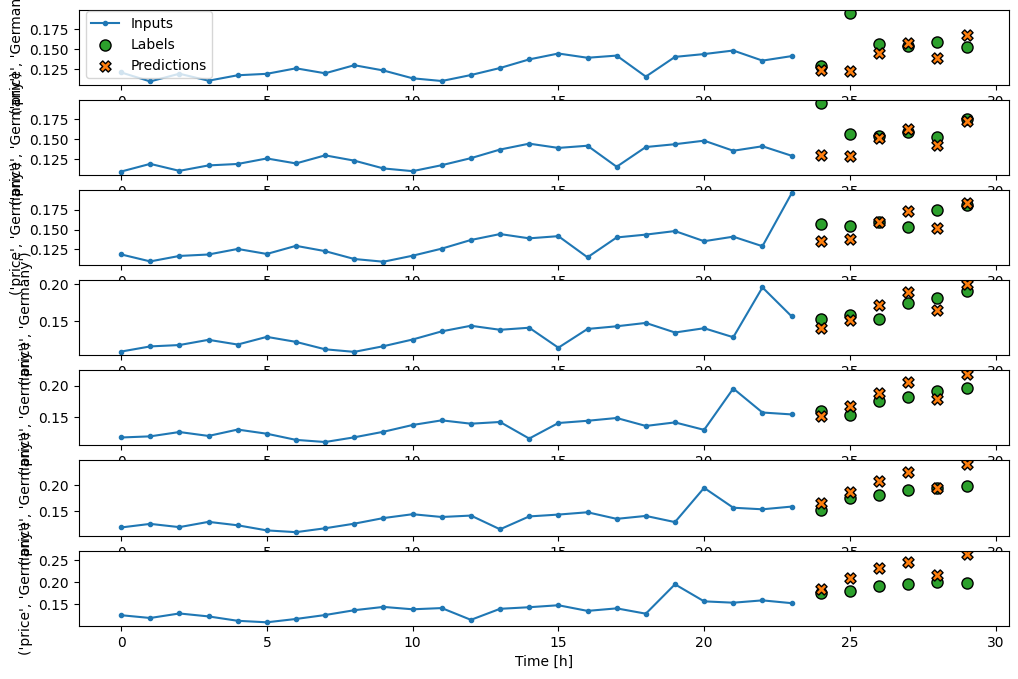

('price', 'Global')


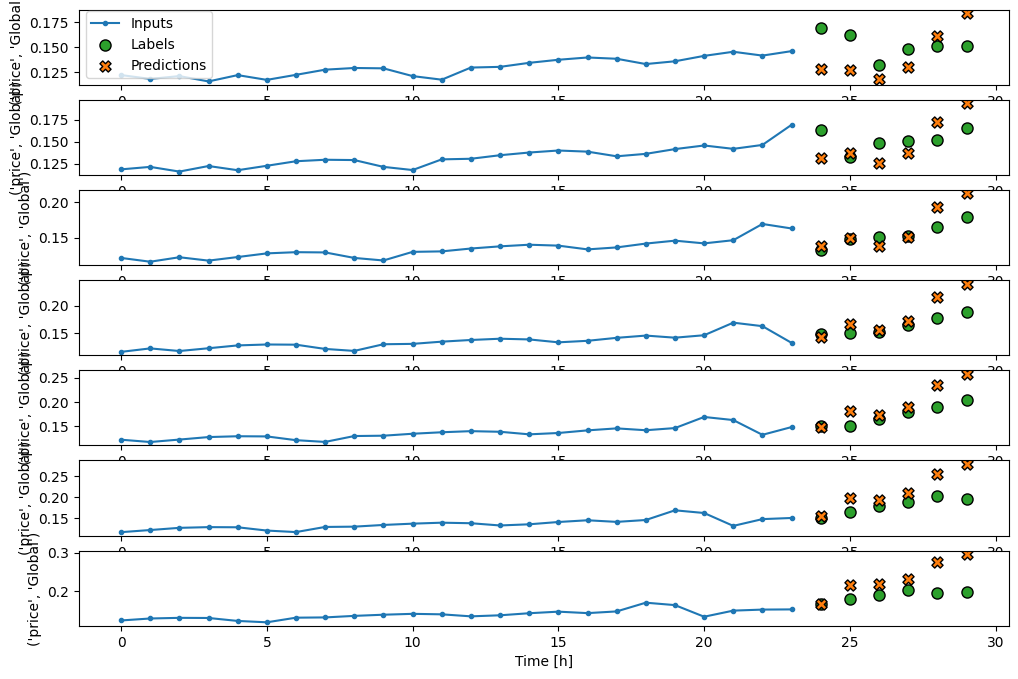

('price', 'Hungary')


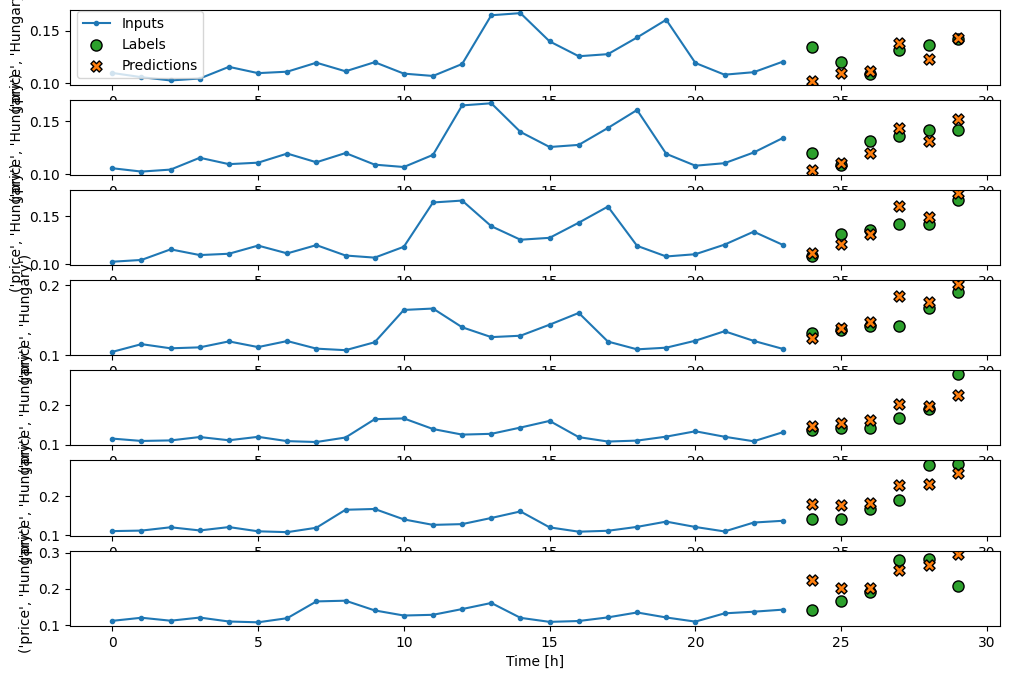

('price', 'Ukraine')


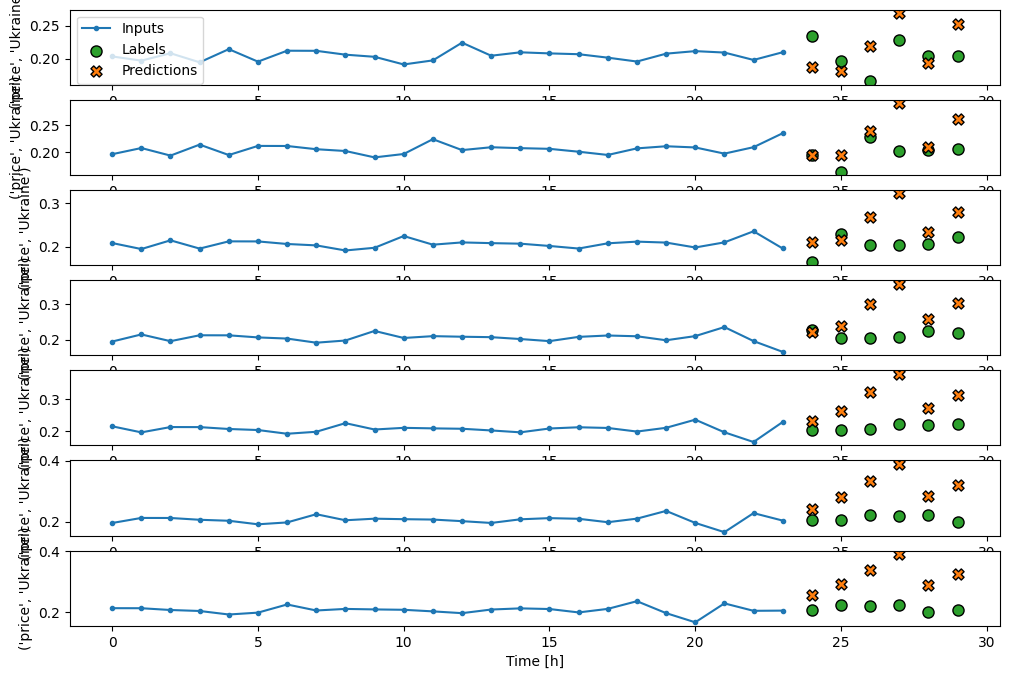

In [25]:
window.test

# val_performance['1'] = m.evaluate(w.val)
for i in range(6):

    label = label_columns[i]
    print(label)
    # performance['1'] = m.evaluate(w.test)
    window.plot(m, plot_col=label, max_subplots=7)


In [26]:
inputs, labels, predictions, weights, mcds = [], [], [], [], []
for x, y in window.test.take(40):
    inputs.append(x)
    lab = y
    lab = window.label_postprocessor.reverse(lab)
    labels.append(lab)
    
    pred = m(x)
    pred = window.label_postprocessor.reverse(pred)
    predictions.append(pred)
    
    weight = m.attention_layer(x, return_weights=True)[1]
    weights.append(weight)
    
    mcd = results.monte_carlo_dropout(x, m, 100, window.label_postprocessor.reverse, return_weight=False)
    mcds.append(mcd)
    weights.append(weight)
    
inputs = tf.concat(inputs, axis=0)
labels = tf.concat(labels, axis=0)
weights = tf.concat(weights, axis=0)
weights = tf.reduce_mean(weights, axis=0)
predictions = tf.concat(predictions, axis=0)
mcds = tf.concat(mcds, axis=1)

In [27]:
np.save(model_path / f"{product}_inputs_{data_type}", inputs.numpy())
np.save(model_path / f"{product}_labels_{data_type}", labels.numpy())
np.save(model_path / f"{product}_weights_{data_type}", weights.numpy())
np.save(model_path / f"{product}_predictions_{data_type}", predictions.numpy())
np.save(model_path / f"{product}_mcd_predictions_{data_type}", mcds.numpy())
